In [2]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pprint
import onnxmltools
from onnxconverter_common.data_types import FloatTensorType
import onnx
import onnxruntime as rt
import numpy as np

c:\Users\yufengq\anaconda3\envs\py39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\yufengq\anaconda3\envs\py39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\yufengq\anaconda3\envs\py39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
df = pd.read_csv(r"C:\Users\yufengq\Desktop\RA\polynomial3.csv")
df.head()

,theta,z,u
0,-20.0,-6.08,-3.92
1,-19.5,-5.58,-4.42
2,-19.1,-5.13,-4.87
3,-18.6,-4.71,-5.29
4,-18.1,-4.32,-5.68


In [4]:
X = df["theta"]
y = df["z"]

X = X.reset_index(drop = True)
y = y.reset_index(drop = True)

X = X.to_numpy().reshape(-1, 1)
y = y.to_numpy().reshape(-1, 1)

# Train the model

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

train_data_linear = lgb.Dataset(X_train, label=y_train,
                        params={
                            'linear_tree': True
                        })

train_data_normal = lgb.Dataset(X_train, label=y_train)

In [6]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "max_depth": 3,
    "num_leaves": 10,
    "learning_rate": 1,
    "verbosity": -1, 
    'num_iterations': 4
}

model_linear = lgb.train(params, train_data_linear)
model_normal = lgb.train(params, train_data_normal)

c:\Users\yufengq\anaconda3\envs\py39\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\yufengq\anaconda3\envs\py39\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [7]:
y_pred_linear = model_linear.predict(X_test, num_iteration=model_linear.best_iteration)
y_pred_normal = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)

In [8]:
print(f"Linear trees error: {round(mean_squared_error(y_test, y_pred_linear),3)}")
print(f"Normal trees error: {round(mean_squared_error(y_test, y_pred_normal),3)}")

Linear trees error: 0.106
Normal trees error: 0.624


# PLot the graph

In [9]:
y_linear = model_linear.predict(X, num_iteration=model_linear.best_iteration)
y_normal = model_normal.predict(X, num_iteration=model_linear.best_iteration)

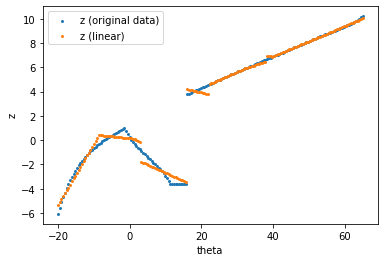

In [10]:
# plotting results
plt.scatter(X, y, label = 'z (original data)', marker = '.', linewidths=0.001)
plt.scatter(X, y_linear, label = 'z (linear)', marker = '.', linewidths=0.001)
plt.ylabel('z')
plt.xlabel('theta')
plt.legend()
plt.show()

# Save the model

In [11]:
model_linear.save_model('linear.txt')

In [12]:
# Load your LightGBM model

# lgb_model = lgb.Booster(model_file=input_lgb_model)

# Convert the LightGBM model into ONNX
# The initial_types argument is a python list.
# Each element is a tuple of a variable name and a type defined in onnxconverter_common/data_types.py
onnx_model = onnxmltools.convert_lightgbm(model_linear, initial_types=[('theta', FloatTensorType((None, X.shape[1])))])

# Save as protobuf

# onnxmltools.utils.save_model(onnx_model, output_onnx_model)

The maximum opset needed by this model is only 8.


In [13]:
converted_model = onnx.load(r"C:\Users\yufengq\Desktop\RA\model.onnx")

In [14]:
converted_model

ir_version: 3
producer_name: "OnnxMLTools"
producer_version: "1.13.0"
domain: "onnxconverter-common"
model_version: 0
doc_string: ""
graph {
  node {
    input: "theta"
    output: "variable"
    name: "LgbmRegressor"
    op_type: "TreeEnsembleRegressor"
    attribute {
      name: "n_targets"
      i: 1
      type: INT
    }
    attribute {
      name: "nodes_falsenodeids"
      ints: 2
      ints: 4
      ints: 6
      ints: 0
      ints: 0
      ints: 0
      ints: 8
      ints: 0
      ints: 0
      ints: 2
      ints: 4
      ints: 6
      ints: 0
      ints: 0
      ints: 0
      ints: 8
      ints: 0
      ints: 0
      ints: 2
      ints: 4
      ints: 0
      ints: 6
      ints: 8
      ints: 0
      ints: 0
      ints: 0
      ints: 0
      ints: 2
      ints: 4
      ints: 6
      ints: 0
      ints: 0
      ints: 0
      ints: 8
      ints: 0
      ints: 0
      type: INTS
    }
    attribute {
      name: "nodes_featureids"
      ints: 0
      ints: 0
      ints: 0
      i

In [15]:
onnx.checker.check_model(converted_model)

In [16]:
sess = rt.InferenceSession(r"C:\Users\yufengq\Desktop\RA\model.onnx")
result = sess.run(None, {'theta': X.astype(np.float32)})
np.array(result).shape

(1, 180, 1)

In [17]:
txt_model = lgb.Booster(model_file=r'C:\Users\yufengq\Desktop\RA\linear.txt')
txt_model.predict(X).shape

(180,)

# Plot the tree

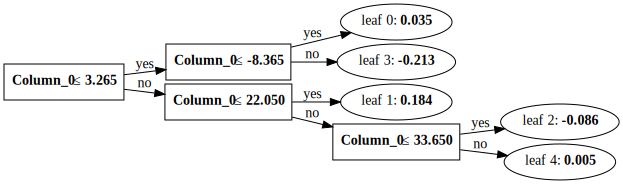

In [18]:
p = lgb.create_tree_digraph(model_linear, 3)
p

# Parse the tree

In [19]:
# change the model to json format
whole_model = model_linear.dump_model()
node  = whole_model['tree_info'][-1]["tree_structure"]

In [20]:
# whole_model

In [21]:
tree = {}

tree['parameters'] = model_linear.params

for i in range(whole_model['tree_info'][-1]['tree_index']+1):

    node  = whole_model['tree_info'][i]["tree_structure"]

    queue = [node]
    dict = {}

    # the very first node
    dict["split"+str(queue[0]["split_index"])] = {'threshold': queue[0]["threshold"],
                                    'split_feature': queue[0]["split_feature"] }

    # flow though the tree
    while queue:

        # left child
        if "left_child" in queue[0].keys():
            queue.append(queue[0]["left_child"])
            # child is a split
            if "split_index" in queue[0]["left_child"].keys():
                dict["split"+str(queue[0]["left_child"]["split_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                            'direction': 'left',
                                                            'threshold': queue[0]["left_child"]["threshold"], 
                                                            'split_feature': queue[0]["left_child"]["split_feature"]}
            # child is a leaf
            else:
                dict["leaf"+str(queue[0]["left_child"]["leaf_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                            'direction': 'left', 
                                                            'leaf_const': queue[0]["left_child"]["leaf_const"], 
                                                            'leaf_coeff': queue[0]["left_child"]["leaf_coeff"]}
                
        # right child
        if "right_child" in queue[0].keys():
            queue.append(queue[0]["right_child"])      
            # child is a split
            if "split_index" in queue[0]["right_child"].keys():
                dict["split"+str(queue[0]["right_child"]["split_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                            'direction': 'right',
                                                            'threshold': queue[0]["right_child"]["threshold"], 
                                                            'split_feature': queue[0]["right_child"]["split_feature"]}
            # child is a leaf
            else:
                dict["leaf"+str(queue[0]["right_child"]["leaf_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                            'direction': 'right',
                                                            'leaf_const': queue[0]["right_child"]["leaf_const"], 
                                                            'leaf_coeff': queue[0]["right_child"]["leaf_coeff"]}
        # delet the first node
        queue.pop(0)

        tree['tree'+str(i)] = dict

In [22]:
queue = [node]
dict = {}

# the very first node
dict["split"+str(queue[0]["split_index"])] = {'threshold': queue[0]["threshold"],
                                 'split_feature': queue[0]["split_feature"] }

# flow though the tree
while queue:

    # left child
    if "left_child" in queue[0].keys():
        queue.append(queue[0]["left_child"])
        # child is a split
        if "split_index" in queue[0]["left_child"].keys():
            dict["split"+str(queue[0]["left_child"]["split_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                           'direction': 'left',
                                                           'threshold': queue[0]["left_child"]["threshold"], 
                                                           'split_feature': queue[0]["left_child"]["split_feature"]}
        # child is a leaf
        else:
            dict["leaf"+str(queue[0]["left_child"]["leaf_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                          'direction': 'left', 
                                                          'leaf_const': queue[0]["left_child"]["leaf_const"], 
                                                          'leaf_coeff': queue[0]["left_child"]["leaf_coeff"]}
            
    # right child
    if "right_child" in queue[0].keys():
        queue.append(queue[0]["right_child"])      
        # child is a split
        if "split_index" in queue[0]["right_child"].keys():
            dict["split"+str(queue[0]["right_child"]["split_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                           'direction': 'right',
                                                           'threshold': queue[0]["right_child"]["threshold"], 
                                                           'split_feature': queue[0]["right_child"]["split_feature"]}
        # child is a leaf
        else:
            dict["leaf"+str(queue[0]["right_child"]["leaf_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                          'direction': 'right',
                                                          'leaf_const': queue[0]["right_child"]["leaf_const"], 
                                                          'leaf_coeff': queue[0]["right_child"]["leaf_coeff"]}
    # delet the first node
    queue.pop(0)

In [23]:
dict

{'split0': {'threshold': 3.2650000000000006, 'split_feature': 0},
 'split2': {'parent': 'split0',
  'direction': 'left',
  'threshold': -8.364999999999998,
  'split_feature': 0},
 'split1': {'parent': 'split0',
  'direction': 'right',
  'threshold': 22.050000000000004,
  'split_feature': 0},
 'leaf0': {'parent': 'split2',
  'direction': 'left',
  'leaf_const': -0.2902764210366918,
  'leaf_coeff': [-0.02229777591165156]},
 'leaf3': {'parent': 'split2',
  'direction': 'right',
  'leaf_const': -0.2451576806147419,
  'leaf_coeff': [-0.012823549889195006]},
 'leaf1': {'parent': 'split1',
  'direction': 'left',
  'leaf_const': 0.7182081149997852,
  'leaf_coeff': [-0.039159652311451076]},
 'split3': {'parent': 'split1',
  'direction': 'right',
  'threshold': 33.65000000000001,
  'split_feature': 0},
 'leaf2': {'parent': 'split3',
  'direction': 'left',
  'leaf_const': -0.8220879353385486,
  'leaf_coeff': [0.02656011635781838]},
 'leaf4': {'parent': 'split3',
  'direction': 'right',
  'leaf_co

In [25]:
dict['leaf0'].keys()

dict_keys(['parent', 'direction', 'leaf_const', 'leaf_coeff'])

In [27]:
dict['split1'].keys()

dict_keys(['parent', 'direction', 'threshold', 'split_feature'])

coefficient and conatant could be a list to contain multivariables